In [2]:
from datetime import date, datetime as dt, timedelta as td
import pytz
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, SimpleRNN
import warnings
warnings.filterwarnings("ignore")

from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [ ]:
#!pip insyall kerastuner
#from kerastuner.tuners import BayesianOptimization

Mount the Drive and define the path to the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = 'drive/MyDrive/Colab Notebooks/StepCount.csv'

In [5]:
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

## Import the data

In [6]:
data = pd.read_csv(PATH)

## Preprocess the data

In [7]:
def convert_steps(steps, grouping=['date']):
  convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('Europe/Vilnius'))
  get_year = lambda x: convert_tz(x).year
  get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
  get_date = lambda x: '{}-{:02}-{:02}'.format(convert_tz(x).year, convert_tz(x).month, convert_tz(x).day) #inefficient
  get_day = lambda x: convert_tz(x).day
  get_hour = lambda x: convert_tz(x).hour
  get_minute = lambda x: convert_tz(x).minute
  get_day_of_week = lambda x: convert_tz(x).weekday()


  steps['startDate'] = pd.to_datetime(steps['startDate'])
  steps['year'] = steps['startDate'].map(get_year)
  steps['month'] = steps['startDate'].map(get_month)
  steps['date'] = steps['startDate'].map(get_date)
  steps['day'] = steps['startDate'].map(get_day)
  steps['hour'] = steps['startDate'].map(get_hour)
  steps['dow'] = steps['startDate'].map(get_day_of_week)

  return steps.groupby(grouping)['value'].sum().reset_index(name='Steps')

In [8]:
def prepare_sequence(sequence, n_previous, n_future):
    """
    Input: 
        - sequence: numpy array, pandas DataFrame or list; input sequence
        - n_previous: int; number of past data points (N)
        - n_future: int; number of data points to be predicted (K)
    Returns:
        - X: (seq. length x n_previous) numpy array with the previous observations
        - y: (seq. length x n_fututre) numpy array with the target observations
    """
    
    X, y = [], []
    idx, i = 0, 0
    while idx+n_future <= len(sequence)-1:
        idx = i + n_previous
        X.append(sequence[i:idx])
        y.append(sequence[idx:idx+n_future])
        i += 1
        
    return np.array(X), np.array(y)


def season(month):
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4


def augment(steps):
    augmented = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')
    dow = steps.groupby(['date']).mean()['dow']
    augmented['dow'] = (dow.apply(int) + 1).to_list()
    month = augmented.date.apply(lambda a: int(a.split('-')[1]))
    augmented['season'] = month.apply(season)
    
    return augmented

In [9]:
steps_by_date = convert_steps(data)
steps_by_date_hour = convert_steps(data, ['date', 'hour'])

# Remove an invalid day
steps_by_date = steps_by_date.iloc[:-1]

# Replace the unrealistic values with the median
steps_by_date.Steps[steps_by_date.Steps < 300] = steps_by_date.Steps.median()

### Configurations

Days:
- 7 previous days to predict the next day
- 14 previous days to predict the next day

Hours:
- 24 previous hours to predict the next hour
- 24 previous hours to predict the next 6 hours
- 24 previous hours to predict the next 12 hours
- 48 previous hours to predict the next 24 hours

In [ ]:
augmented_steps_by_date = augment(data)

In [ ]:
sm_s = augmented_steps_by_date.Steps.mean()
sd_s = augmented_steps_by_date.Steps.std()

sm_d = augmented_steps_by_date.dow.mean()
sd_d = augmented_steps_by_date.dow.std()

sm_se = augmented_steps_by_date.season.mean()
sd_se = augmented_steps_by_date.season.std()

augmented_steps_by_date.Steps = (augmented_steps_by_date.Steps - sm_s)/sd_s
augmented_steps_by_date.dow = (augmented_steps_by_date.dow - sm_d)/sd_d
augmented_steps_by_date.season = (augmented_steps_by_date.season - sm_se)/sd_se

In [ ]:
augmented_steps_by_date

,date,Steps,dow,season
0,2015-08-06,2.246849,-0.000996,0.419764
1,2015-08-07,-0.909211,0.498880,0.419764
2,2015-08-08,-0.496829,0.998756,0.419764
3,2015-08-09,-1.257009,1.498631,0.419764
4,2015-08-10,1.120503,-1.500623,0.419764
...,...,...,...,...
2003,2021-02-05,-0.934293,0.498880,-1.328963
2004,2021-02-06,0.313318,0.998756,-1.328963
2005,2021-02-07,0.573229,1.498631,-1.328963
2006,2021-02-08,-0.119208,-1.500623,-1.328963


---

# 7 previous days to predict the next day

In [10]:
seven_one_results = pd.DataFrame(columns=['Name', 'MAE'])

## Baseline ARIMA

In [ ]:
X_baseline = steps_by_date['Steps']
size = int(len(X_baseline) * 0.9)
train, test = X_baseline[0:size], X_baseline[size:len(X_baseline)]

mean = train.mean()
std = train.std()

# Normalize
train = (train - mean) / std
test = (test - mean) / std

train = train.to_list()
test = test.to_list()
history = [x for x in train]

In [ ]:
baseline_predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(7,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	baseline_predictions.append(output[0])
	history.append(test[t])

In [ ]:
rmse = sqrt(mean_squared_error(test, baseline_predictions))
print('Test RMSE: %.3f' % rmse)

mae = mean_absolute_error(test, baseline_predictions)
print('Test MAE: %.3f' % mae)

seven_one_results.loc[0] = ["ARMIA", mae]

Test RMSE: 0.719
Test MAE: 0.529


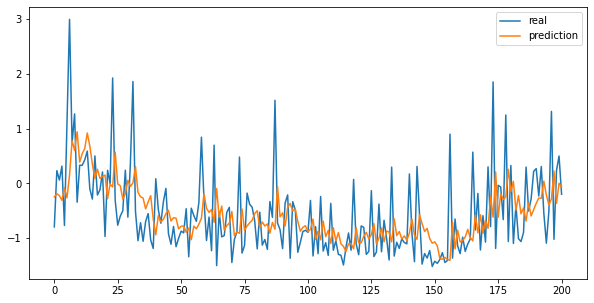

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test)
plt.plot(baseline_predictions)
plt.legend(["real", "prediction"])

## Baseline Last N Averaged

In [11]:
def average(history, n):
  return np.mean(history[-n:])


X_baseline = steps_by_date['Steps']
size = int(len(X_baseline) * 0.9)
train, test = X_baseline[0:size], X_baseline[size:len(X_baseline)]

mean = train.mean()
std = train.std()

# Normalize
train = (train - mean) / std
test = (test - mean) / std

train = train.to_list()
test = test.to_list()
history = [x for x in train]


baseline_predictions = list()
# walk-forward validation
for t in range(len(test)):
    baseline_predictions.append(average(history, 7))
    history.append(test[t])
 

rmse = sqrt(mean_squared_error(test, baseline_predictions))
print('Test RMSE: %.3f' % rmse)

mse = mean_absolute_error(test, baseline_predictions)
print('Test MSE:', mse)

Test RMSE: 0.708
Test MSE: 0.5225247944548129


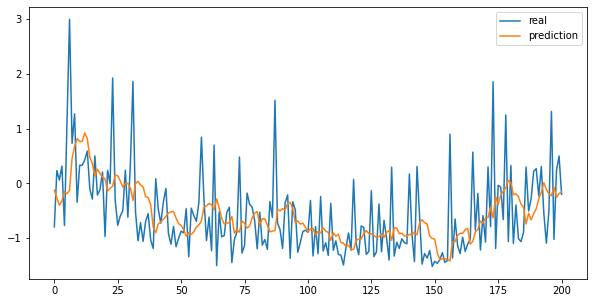

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(test)
plt.plot(baseline_predictions)
plt.legend(["real", "prediction"])

---

# LSTM
## 7 previous days to predict the next day 


## Vanilla LSTM

In [ ]:
# Prepre the seqcuence so that X corresponds to 7 prvious days and y corresponds to the next day
X, y = prepare_sequence(steps_by_date['Steps'], 7, 1)
X = X.reshape(X.shape[0], X.shape[1], 1)
print("Shape of X and y after sequence preparation:", X.shape, y.shape)

# Split
coef = 0.1
split_size = int(len(X) * (1 - coef))

X_train, X_test = X[:split_size], X[split_size:]
y_train, y_test = y[:split_size], y[split_size:]

# Compute mean and SD of the training set
mean = X_train.mean()
std = X_train.std()

# Normalize
X_train = (X_train - mean) / std
y_train = (y_train - mean) / std
X_test = (X_test - mean) / std
y_test = (y_test - mean) / std

# Print the sahpe of the data
print("The shape of the training set:", X_train.shape, y_train.shape)
print("The shape of the test set:", X_test.shape, y_test.shape)

Shape of X and y after sequence preparation: (2000, 7, 1) (2000, 1)
The shape of the training set: (1800, 7, 1) (1800, 1)
The shape of the test set: (200, 7, 1) (200, 1)


In [ ]:
def vanilla_LSTM(output_size, n_timestamps, n_features):
  model = Sequential()
  model.add(LSTM(output_size, input_shape=(n_timestamps, n_features), activation='tanh'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
  return model


single_model = vanilla_LSTM(100, X_train.shape[1], X_train.shape[2])
#print(single_model.summary())

# Fit the model
history = single_model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=6)


# MAE
single_predictions = single_model.predict(X_test)
print("Mean absolute error:", mean_absolute_error(y_test, single_predictions))

Epoch 1/20
300/300 [==============================] - 2s 3ms/step - loss: 1.1603 - mean_absolute_error: 0.8245
Epoch 2/20
300/300 [==============================] - 1s 2ms/step - loss: 1.1032 - mean_absolute_error: 0.8017
Epoch 3/20
300/300 [==============================] - 1s 2ms/step - loss: 1.0881 - mean_absolute_error: 0.7947
Epoch 4/20
300/300 [==============================] - 1s 2ms/step - loss: 1.0826 - mean_absolute_error: 0.7912
Epoch 5/20
300/300 [==============================] - 1s 2ms/step - loss: 1.0797 - mean_absolute_error: 0.7896
Epoch 6/20
300/300 [==============================] - 1s 2ms/step - loss: 1.0782 - mean_absolute_error: 0.7886
Epoch 7/20
300/300 [==============================] - 1s 2ms/step - loss: 1.0770 - mean_absolute_error: 0.7879
Epoch 8/20
300/300 [==============================] - 1s 2ms/step - loss: 1.0757 - mean_absolute_error: 0.7873
Epoch 9/20
300/300 [==============================] - 1s 2ms/step - loss: 1.0742 - mean_absolute_error: 0.7867
E

In [ ]:
seven_one_results.loc[1] = ["Vanilla LSTM", mean_absolute_error(y_test, single_predictions)]

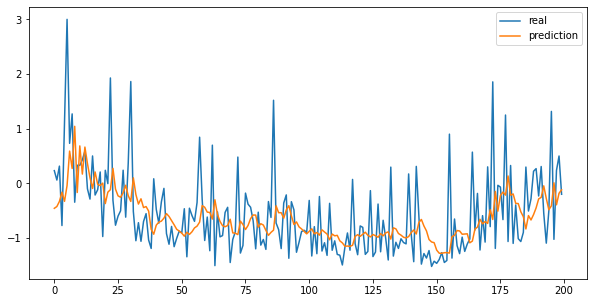

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test)
plt.plot(single_predictions)
plt.legend(["real", "prediction"])

## Stacked LSTM

In [ ]:
def stacked_LSTM(n_timestamps, n_features):
  model = Sequential()
  model.add(LSTM(248, activation='tanh', input_shape=(n_timestamps, n_features), return_sequences=True))
  model.add(LSTM(124, activation='tanh', return_sequences=True))
  model.add(LSTM(62, activation='tanh'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])

  return model

stacked_model = stacked_LSTM(X_train.shape[1], X_train.shape[2])
#print(stacked_model.summary())

stacked_model_history = stacked_model.fit(X_train, y_train, epochs=20, shuffle=False, verbose=0, batch_size=4)


# MAE
stacked_model_predictions = stacked_model.predict(X_test)
print("Mean absolute error:", mean_absolute_error(y_test, stacked_model_predictions))

Mean absolute error: 0.5340264102175865


In [ ]:
seven_one_results.loc[2] = ["Stacked LSTM", mean_absolute_error(y_test, stacked_model_predictions)]

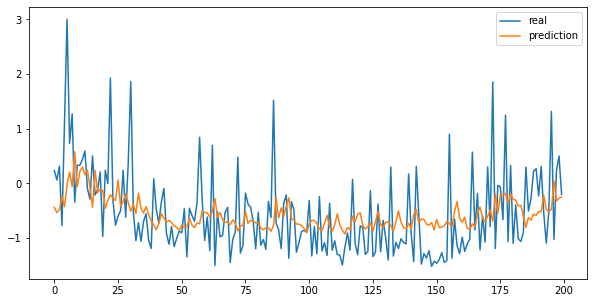

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test)
plt.plot(stacked_model_predictions)
plt.legend(["real", "prediction"])

## Biderectional LSTM

In [ ]:
def BLSTM(output_size, n_timestamps, n_features):
  model = Sequential()
  model.add(Bidirectional(LSTM(output_size, activation='tanh'), input_shape=(n_timestamps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model


blstm_model = BLSTM(300, X_train.shape[1], X_train.shape[2])
blstm_history = blstm_model.fit(X_train, y_train, epochs=20, shuffle=False, verbose=0, batch_size=1)

# MAE
blstm_model_predictions = blstm_model.predict(X_test)
error = mean_absolute_error(y_test, blstm_model_predictions)
error

0.5497715738363658

In [ ]:
seven_one_results.loc[3] = ["BLSTM", mean_absolute_error(y_test, blstm_model_predictions)]

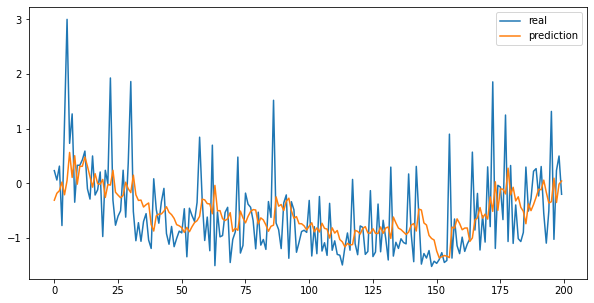

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test)
plt.plot(blstm_model_predictions)
plt.legend(["real", "prediction"])

---

## Simple RNN

In [36]:
def simple_RNN(output_size, n_timestamps, n_features):
  model = Sequential()
  model.add(SimpleRNN(output_size, activation='relu', input_shape=(n_timestamps, n_features)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')

  return model


simple_RNN_model = simple_RNN(100, X_train.shape[1], X_train.shape[2])
simple_RNN_history = simple_RNN_model.fit(X_train, y_train, epochs=20, shuffle=False, verbose=1, batch_size=6)

# MAE
simple_RNN_model_predictions = simple_RNN_model.predict(X_test)
error = mean_absolute_error(y_test, simple_RNN_model_predictions)
error

Epoch 1/20
300/300 [==============================] - 5s 6ms/step - loss: 1.1987
Epoch 2/20
300/300 [==============================] - 2s 7ms/step - loss: 1.1672
Epoch 3/20
300/300 [==============================] - 2s 6ms/step - loss: 1.1484
Epoch 4/20
300/300 [==============================] - 2s 6ms/step - loss: 1.1325
Epoch 5/20
300/300 [==============================] - 2s 6ms/step - loss: 1.1185
Epoch 6/20
300/300 [==============================] - 2s 8ms/step - loss: 1.0981
Epoch 7/20
300/300 [==============================] - 2s 6ms/step - loss: 1.0831
Epoch 8/20
300/300 [==============================] - 2s 6ms/step - loss: 1.0597
Epoch 9/20
300/300 [==============================] - 2s 5ms/step - loss: 1.0362
Epoch 10/20
300/300 [==============================] - 2s 5ms/step - loss: 1.0156
Epoch 11/20
300/300 [==============================] - 2s 5ms/step - loss: 0.9828
Epoch 12/20
300/300 [==============================] - 2s 6ms/step - loss: 0.9516
Epoch 13/20
300/300 [====

ValueError: ignored

In [ ]:
seven_one_results.loc[4] = ["Simple RNN", mean_absolute_error(y_test, simple_RNN_model_predictions)]

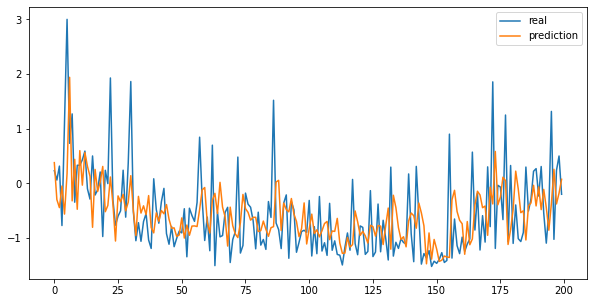

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test)
plt.plot(simple_RNN_model_predictions)
plt.legend(["real", "prediction"])

---

## Stacked RNN

In [ ]:
def stacked_RNN(n_timestamps, n_features):
  model = Sequential()
  model.add(SimpleRNN(480, activation='relu', input_shape=(n_timestamps, n_features), return_sequences=True))
  model.add(SimpleRNN(240, activation='relu', return_sequences=True))
  model.add(SimpleRNN(120, activation='relu', return_sequences=True))
  model.add(SimpleRNN(60, activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
  return model


stacked_RNN_model = stacked_RNN(X_train.shape[1], X_train.shape[2])
stacked_RNN_history = stacked_RNN_model.fit(X_train, y_train, epochs=20, shuffle=False, verbose=0, batch_size=16)


# MAE
stacked_RNN_model_predictions = stacked_RNN_model.predict(X_test)
error = mean_absolute_error(y_test, stacked_RNN_model_predictions)
error

0.5444337538071323

In [ ]:
seven_one_results.loc[5] = ["Stacked RNN", mean_absolute_error(y_test, stacked_RNN_model_predictions)]

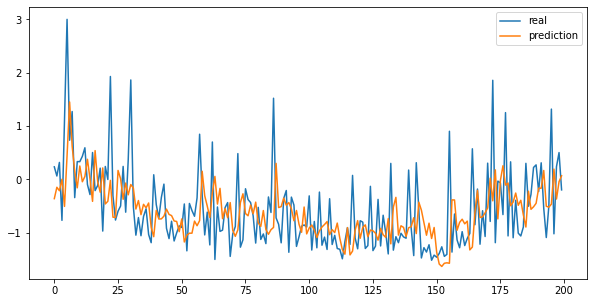

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test)
plt.plot(stacked_RNN_model_predictions)
plt.legend(["real", "prediction"])

---

## CNN LSTM

In [ ]:
# Prepre the seqcuence so that X corresponds to 8 prvious days and y corresponds to the next day
X_cnn_lstm, y_cnn_lstm = prepare_sequence(steps_by_date['Steps'], 8, 1)

X_cnn_lstm = X_cnn_lstm.reshape(X_cnn_lstm.shape[0], 2, X_cnn_lstm.shape[1]//2, 1)
print("Shape of X and y after sequence preparation:", X_cnn_lstm.shape, y_cnn_lstm.shape)

# Split
coef = 0.1
split_size = int(len(X_cnn_lstm) * (1 - coef))

X_cl_train, X_cl_test = X_cnn_lstm[:split_size], X_cnn_lstm[split_size:]
y_cl_train, y_cl_test = y_cnn_lstm[:split_size], y_cnn_lstm[split_size:]

# Compute mean and SD of the training set
mean = X_cl_train.mean()
std = X_cl_train.std()

# Normalize
X_cl_train = (X_cl_train - mean) / std
y_cl_train = (y_cl_train - mean) / std
X_cl_test = (X_cl_test - mean) / std
y_cl_test = (y_cl_test - mean) / std

# Print the sahpe of the data
print("The shape of the training set:", X_cl_train.shape, y_cl_train.shape)
print("The shape of the test set:", X_cl_test.shape, y_cl_test.shape)

Shape of X and y after sequence preparation: (1999, 2, 4, 1) (1999, 1)
The shape of the training set: (1799, 2, 4, 1) (1799, 1)
The shape of the test set: (200, 2, 4, 1) (200, 1)


In [ ]:
def CNN_LSTM(n_steps, n_features):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(100, activation='tanh'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model


cnn_lstm_model = CNN_LSTM(X_cl_train.shape[2], X_cl_train.shape[3])
cnn_lstm_history = cnn_lstm_model.fit(X_cl_train, y_cl_train, epochs=20, verbose=0, batch_size=8)


# MAE
cnn_lstm_model_predictions = cnn_lstm_model.predict(X_cl_test)
error = mean_absolute_error(y_cl_test, cnn_lstm_model_predictions)
error

0.5772854469467505

In [ ]:
seven_one_results.loc[6] = ["CNN LSTM", mean_absolute_error(y_test, cnn_lstm_model_predictions)]

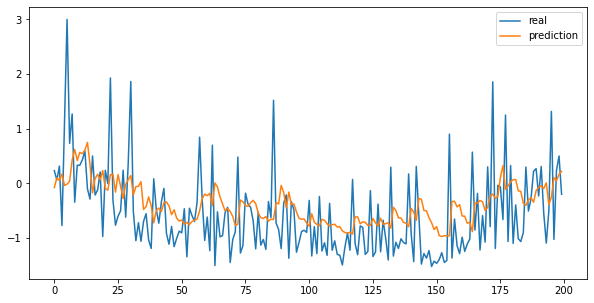

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test)
plt.plot(cnn_lstm_model_predictions)
plt.legend(["real", "prediction"])

---

## ConvLSTM

In [ ]:
# Prepre the seqcuence so that X corresponds to 8 prvious days and y corresponds to the next day
X_conv_lstm, y_conv_lstm = prepare_sequence(steps_by_date['Steps'], 8, 1)

X_conv_lstm = X_conv_lstm.reshape(X_conv_lstm.shape[0], 2, 1, X_conv_lstm.shape[1]//2, 1)
print("Shape of X and y after sequence preparation:", X_conv_lstm.shape, y_conv_lstm.shape)

# Split
coef = 0.1
split_size = int(len(X_conv_lstm) * (1 - coef))

X_cv_train, X_cv_test = X_conv_lstm[:split_size], X_conv_lstm[split_size:]
y_cv_train, y_cv_test = y_conv_lstm[:split_size], y_conv_lstm[split_size:]

# Compute mean and SD of the training set
mean = X_cv_train.mean()
std = X_cv_train.std()

# Normalize
X_cv_train = (X_cv_train - mean) / std
y_cv_train = (y_cv_train - mean) / std
X_cv_test = (X_cv_test - mean) / std
y_cv_test = (y_cv_test - mean) / std

# Print the sahpe of the data
print("The shape of the training set:", X_cv_train.shape, y_cv_train.shape)
print("The shape of the test set:", X_cv_test.shape, y_cv_test.shape)

Shape of X and y after sequence preparation: (1999, 2, 1, 4, 1) (1999, 1)
The shape of the training set: (1799, 2, 1, 4, 1) (1799, 1)
The shape of the test set: (200, 2, 1, 4, 1) (200, 1)


In [ ]:
def Conv_LSTM(n_seq, n_steps, n_features):
  model = Sequential()
  model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='tanh', input_shape=(n_seq, 1, n_steps, n_features)))
  model.add(Flatten())
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

conv_lstm_model = Conv_LSTM(2, X_cv_train.shape[3], X_cv_train.shape[4])
conv_lstm_history = conv_lstm_model.fit(X_cv_train, y_cv_train, epochs=20, verbose=0, batch_size=8)


# MAE
conv_lstm_model_predictions = conv_lstm_model.predict(X_cv_test)
error = mean_absolute_error(y_cv_test, conv_lstm_model_predictions)
error

0.5679572416623974

In [ ]:
seven_one_results.loc[7] = ["ConvLSTM", mean_absolute_error(y_cv_test, conv_lstm_model_predictions)]

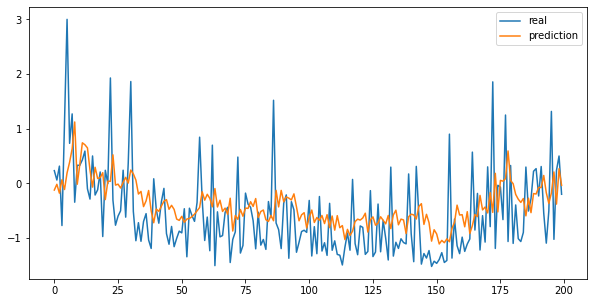

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test)
plt.plot(conv_lstm_model_predictions)
plt.legend(["real", "prediction"])

---

## Results

In [ ]:
seven_one_results.sort_values('MAE')

,Name,MAE
1,Vanilla LSTM,0.519375
3,BLSTM,0.524645
6,CNN LSTM,0.527636
0,ARMIA,0.528772
4,Simple RNN,0.535705
2,Stacked LSTM,0.544576
7,ConvLSTM,0.554316
5,Stacked RNN,0.560777


---

---

# 24 previous hours to predict the next hour

In [ ]:
day_hour_results = pd.DataFrame(columns=['Name', 'MAE'])

## Baseline

In [ ]:
def average(history, n):
  return np.mean(history[-n:])


X_baseline = steps_by_date_hour['Steps']
size = int(len(X_baseline) * 0.9)
train, test = X_baseline[0:size], X_baseline[size:len(X_baseline)]

mean = train.mean()
std = train.std()

# Normalize
train = (train - mean) / std
test = (test - mean) / std

train = train.to_list()
test = test.to_list()
history = [x for x in train]

baseline_predictions = list()
# walk-forward validation
for t in range(len(test)):
    baseline_predictions.append(average(history, 24))
    history.append(test[t])
 

rmse = sqrt(mean_squared_error(test, baseline_predictions))
print('Test RMSE: %.3f' % rmse)

mse = mean_absolute_error(test, baseline_predictions)
print('Test MSE:', mse)

Test RMSE: 0.877
Test MSE: 0.5515446081867739


## Vanilla LSTM

In [ ]:
def prepare_data_LSTM(data, n, k, split_coef=0.1):
    # Prepre the seqcuence so that X corresponds to n prvious days and y corresponds to the next day
    X, y = prepare_sequence(data, n, k)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    print("Shape of X and y after sequence preparation:", X.shape, y.shape)

    # Split
    coef = split_coef
    split_size = int(len(X) * (1 - coef))

    X_train, X_test = X[:split_size], X[split_size:]
    y_train, y_test = y[:split_size], y[split_size:]

    # Compute mean and SD of the training set
    mean = X_train.mean()
    std = X_train.std()

    # Normalize
    X_train = (X_train - mean) / std
    y_train = (y_train - mean) / std
    X_test = (X_test - mean) / std
    y_test = (y_test - mean) / std

    # Print the sahpe of the data
    print("The shape of the training set:", X_train.shape, y_train.shape)
    print("The shape of the test set:", X_test.shape, y_test.shape)

    return X_train, y_train, X_test, y_test

In [ ]:
X_train_24_1, y_train_24_1, X_test_24_1, y_test_24_1 = prepare_data_LSTM(steps_by_date_hour['Steps'].to_numpy(), 23, 1, 0.1)

Shape of X and y after sequence preparation: (24290, 23, 1) (24290, 1)
The shape of the training set: (21861, 23, 1) (21861, 1)
The shape of the test set: (2429, 23, 1) (2429, 1)


In [ ]:
single_LSTM_24_1 = vanilla_LSTM(50, X_train_24_1.shape[1], X_train_24_1.shape[2])
single_LSTM_24_1_history = single_LSTM_24_1.fit(X_train_24_1, y_train_24_1, shuffle=False, epochs=40, validation_split=0.1, batch_size=4, callbacks=[early_stopping_cb])


single_LSTM_24_1_predictions = single_LSTM_24_1.predict(X_test_24_1)

error = mean_absolute_error(y_test_24_1, single_LSTM_24_1_predictions)
print(error)
day_hour_results.loc[0] = ["Vanilla LSTM", error]

Epoch 1/40
4919/4919 [==============================] - 20s 4ms/step - loss: 1.0345 - mean_absolute_error: 0.7516 - val_loss: 0.7489 - val_mean_absolute_error: 0.6429
Epoch 2/40
4919/4919 [==============================] - 18s 4ms/step - loss: 1.0302 - mean_absolute_error: 0.7476 - val_loss: 0.7456 - val_mean_absolute_error: 0.6375
Epoch 3/40
4919/4919 [==============================] - 18s 4ms/step - loss: 1.0278 - mean_absolute_error: 0.7458 - val_loss: 0.7488 - val_mean_absolute_error: 0.6434
Epoch 4/40
4919/4919 [==============================] - 18s 4ms/step - loss: 1.0252 - mean_absolute_error: 0.7451 - val_loss: 0.7504 - val_mean_absolute_error: 0.6453
Epoch 5/40
4919/4919 [==============================] - 18s 4ms/step - loss: 1.0237 - mean_absolute_error: 0.7443 - val_loss: 0.7512 - val_mean_absolute_error: 0.6468
Epoch 6/40
4919/4919 [==============================] - 18s 4ms/step - loss: 1.0224 - mean_absolute_error: 0.7438 - val_loss: 0.7522 - val_mean_absolute_error: 0.648

## Stacked LSTM

In [ ]:
stacked_LSTM_24_1 = Sequential()
stacked_LSTM_24_1.add(LSTM(70, activation='relu', input_shape=(X_train_24_1.shape[1], X_train_24_1.shape[2]), return_sequences=True))
stacked_LSTM_24_1.add(LSTM(10, activation='relu', return_sequences=True))
stacked_LSTM_24_1.add(Dense(1))
stacked_LSTM_24_1.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])


stacked_LSTM_24_1_history = stacked_LSTM_24_1.fit(X_train_24_1, y_train_24_1, shuffle=False, epochs=20, batch_size=16)


stacked_LSTM_24_1_predictions = stacked_LSTM_24_1.predict(X_test_24_1)

error = mean_absolute_error(y_test_24_1, stacked_LSTM_24_1_predictions)
day_hour_results.loc[1] = ["Stacked LSTM", error]

Epoch 1/20
 313/1367 [=====>........................] - ETA: 1:41 - loss: 1.3337 - mean_absolute_error: 0.8536

KeyboardInterrupt: ignored

---

# Hyperparameter tuning

In [ ]:
# Prepre the seqcuence so that X corresponds to 7 prvious days and y corresponds to the next day
X, y = prepare_sequence(steps_by_date['Steps'], 7, 1)
X = X.reshape(X.shape[0], X.shape[1], 1)
print("Shape of X and y after sequence preparation:", X.shape, y.shape)

# Split
coef = 0.1
split_size = int(len(X) * (1 - coef))

X_train, X_test = X[:split_size], X[split_size:]
y_train, y_test = y[:split_size], y[split_size:]

# Compute mean and SD of the training set
mean = X_train.mean()
std = X_train.std()

# Normalize
X_train = (X_train - mean) / std
y_train = (y_train - mean) / std
X_test = (X_test - mean) / std
y_test = (y_test - mean) / std

# Print the sahpe of the data
print("The shape of the training set:", X_train.shape, y_train.shape)
print("The shape of the test set:", X_test.shape, y_test.shape)

Shape of X and y after sequence preparation: (2000, 7, 1) (2000, 1)
The shape of the training set: (1800, 7, 1) (1800, 1)
The shape of the test set: (200, 7, 1) (200, 1)


In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(LSTM(units=hp.Int('units',min_value=1, max_value=1024, step=32), 
            activation='tanh', input_shape=(X_train_24_1.shape[1], X_train_24_1.shape[2])))
    #model.add(Dense(units=hp.Int('units',min_value=32, max_value=512, step=32), activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mse', metrics=['mse'], optimizer=Adam(
      hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
      )

  return model


bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='val_mse',
    max_trials=20,
    executions_per_trial=1,
    directory=".",
    project_name='lstm_tuning',
    overwrite=True)

bayesian_opt_tuner.search(X_train_24_1, y_train_24_1, epochs=100,
     #validation_data=(X_test, y_test),
     validation_split=0.2, 
     verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)], batch_size=16)


bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

hyper_predictions = model.predict(X_test_24_1)
print("Mean absolute error:", mean_absolute_error(y_test_24_1, hyper_predictions))

Trial 20 Complete [00h 01m 22s]
val_mse: 0.8087588548660278

Best val_mse So Far: 0.7978683710098267
Total elapsed time: 00h 25m 28s
INFO:tensorflow:Oracle triggered exit
Mean absolute error: 0.5840874420850998


Mean absolute error: 0.5303063001737148


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 129)               67596     
_________________________________________________________________
dense (Dense)                (None, 1)                 130       
Total params: 67,726
Trainable params: 67,726
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def vanilla_LSTM(output_size, n_timestamps, n_features):
  model = Sequential()
  model.add(LSTM(output_size, input_shape=(n_timestamps, n_features), activation='tanh'))
  model.add(Dense(1))
  model.compile(optimizer=Adam(0.01), loss='mse', metrics=['mean_absolute_error'])
  return model


single_model = vanilla_LSTM(1, X_train.shape[1], X_train.shape[2])
#print(single_model.summary())

# Fit the model
history = single_model.fit(X_train, y_train, epochs=200, shuffle=False, batch_size=4)


# MAE
single_predictions = single_model.predict(X_test)
print("Mean absolute error:", mean_absolute_error(y_test, single_predictions))

Epoch 1/200
450/450 [==============================] - 3s 3ms/step - loss: 1.1941 - mean_absolute_error: 0.8308
Epoch 2/200
450/450 [==============================] - 1s 2ms/step - loss: 1.1738 - mean_absolute_error: 0.8260
Epoch 3/200
450/450 [==============================] - 1s 2ms/step - loss: 1.1496 - mean_absolute_error: 0.8215
Epoch 4/200
450/450 [==============================] - 1s 2ms/step - loss: 1.1391 - mean_absolute_error: 0.8192
Epoch 5/200
450/450 [==============================] - 1s 2ms/step - loss: 1.1342 - mean_absolute_error: 0.8178
Epoch 6/200
450/450 [==============================] - 1s 2ms/step - loss: 1.1312 - mean_absolute_error: 0.8168
Epoch 7/200
450/450 [==============================] - 1s 2ms/step - loss: 1.1291 - mean_absolute_error: 0.8160
Epoch 8/200
450/450 [==============================] - 1s 2ms/step - loss: 1.1275 - mean_absolute_error: 0.8154
Epoch 9/200
450/450 [==============================] - 1s 2ms/step - loss: 1.1262 - mean_absolute_error:

In [34]:
def average(history, n, k):
  if k == 1:
    return np.mean(history[-n:])
  else:
    predictions = []
    while k != 0:
      prediction = np.mean(history[-n:])
      predictions.append(prediction)
      history.append(prediction)
      k -= 1
    return predictions


X_baseline = steps_by_date['Steps']
size = int(len(X_baseline) * 0.9)
train, test = X_baseline[0:size], X_baseline[size:len(X_baseline)]

mean = train.mean()
std = train.std()

# Normalize
train = (train - mean) / std
test = (test - mean) / std

train = train.to_list()
test = test.to_list()
history = [x for x in train]


baseline_predictions = list()
# walk-forward validation
for t in range(len(test)):
    baseline_predictions.append(average(history, 7, 2))
    history.append(test[t])
 

#rmse = sqrt(mean_squared_error(test, baseline_predictions))
#print('Test RMSE: %.3f' % rmse)

#mse = mean_absolute_error(test, baseline_predictions)
#print('Test MSE:', mse)

In [80]:
# Prepre the seqcuence so that X corresponds to 7 prvious days and y corresponds to the next day
X, y = prepare_sequence(steps_by_date['Steps'], 7, 1)
X = X.reshape(X.shape[0], X.shape[1], 1)
print("Shape of X and y after sequence preparation:", X.shape, y.shape)

# Split
coef = 0.1
split_size = int(len(X) * (1 - coef))

X_train, X_test = X[100:split_size], X[split_size:]
y_train, y_test = y[100:split_size], y[split_size:]

# Compute mean and SD of the training set
mean = X_train.mean()
std = X_train.std()

# Normalize
X_train = (X_train - mean) / std
y_train = (y_train - mean) / std
X_test = (X_test - mean) / std
y_test = (y_test - mean) / std

# Print the sahpe of the data
print("The shape of the training set:", X_train.shape, y_train.shape)
print("The shape of the test set:", X_test.shape, y_test.shape)

Shape of X and y after sequence preparation: (2000, 7, 1) (2000, 1)
The shape of the training set: (1700, 7, 1) (1700, 1)
The shape of the test set: (200, 7, 1) (200, 1)


In [35]:
mean_absolute_error(y_test, np.array(baseline_predictions)[:-1])

0.5111950197806541

In [81]:
def vanilla_LSTM(output_size, n_timestamps, n_features):
  model = Sequential()
  model.add(LSTM(output_size, input_shape=(n_timestamps, n_features), activation='tanh'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
  return model


single_model = vanilla_LSTM(100, X_train.shape[1], X_train.shape[2])
#print(single_model.summary())

# Fit the model
history = single_model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=6)


# MAE
single_predictions = single_model.predict(X_test)
print("Mean absolute error:", mean_absolute_error(y_test, single_predictions))

Epoch 1/20
284/284 [==============================] - 2s 3ms/step - loss: 1.0201 - mean_absolute_error: 0.7567
Epoch 2/20
284/284 [==============================] - 1s 3ms/step - loss: 1.0075 - mean_absolute_error: 0.7539
Epoch 3/20
284/284 [==============================] - 1s 3ms/step - loss: 1.0076 - mean_absolute_error: 0.7520
Epoch 4/20
284/284 [==============================] - 1s 4ms/step - loss: 1.0055 - mean_absolute_error: 0.7497
Epoch 5/20
284/284 [==============================] - 1s 4ms/step - loss: 1.0047 - mean_absolute_error: 0.7486
Epoch 6/20
284/284 [==============================] - 1s 4ms/step - loss: 1.0038 - mean_absolute_error: 0.7480
Epoch 7/20
284/284 [==============================] - 1s 3ms/step - loss: 1.0027 - mean_absolute_error: 0.7476
Epoch 8/20
284/284 [==============================] - 1s 3ms/step - loss: 1.0009 - mean_absolute_error: 0.7472
Epoch 9/20
284/284 [==============================] - 1s 4ms/step - loss: 1.0000 - mean_absolute_error: 0.7470
E

In [42]:
single_predictions[0]

array([-0.29809707, -0.22384419], dtype=float32)

In [43]:
y_test[0]

array([-0.79458599,  0.23436896])